## 1. Importing the requisite packages

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import contextily

## 2. Creating Summary Spatial Features - One Dataset

In [3]:
data_path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

dg_pdf = pd.read_csv(data_path + 'DollarGeneralStores_22815.csv')
dg_pdf.drop(columns=['geometry'], inplace=True)

# Converting the pandas dataframe into a geopandas geodataframe
dg_gdf = gpd.GeoDataFrame(
    dg_pdf, geometry=gpd.points_from_xy(dg_pdf.x, dg_pdf.y)
)
dg_gdf.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
# Setting the CRS
dg_gdf = dg_gdf.set_crs('epsg:4326')

In [4]:
dg_gdf.head()

ID                                            address          x  \
0   2  East Waterloo Road, Thomastown, Coventry Cross... -81.504004   
1   3  South Main Street, Stadium District, Downtown,... -81.525667   
2   4  Vernon Odom Boulevard, Rolling Acres, West Akr... -81.581174   
3   6  Merriman Road, Waters Edge, Merriman Valley, A... -81.553193   
4   8  Canton Road, Ellet, Akron, Springfield Townshi... -81.431217   

           y                    geometry  
0  41.029200  POINT (-81.50400 41.02920)  
1  41.069305  POINT (-81.52567 41.06930)  
2  41.059780  POINT (-81.58117 41.05978)  
3  41.134927  POINT (-81.55319 41.13493)  
4  41.036011  POINT (-81.43122 41.03601)

In [5]:
# To create a buffer, we first need to convert from a g-crs to a p-crs
dg_gdf = dg_gdf.to_crs(3005)

# Next, create aggregation area around each Dollar General store
buffer_size_mi = 5
buffer_size_m = buffer_size_mi * 1609.344 # meters in a mile

# Creating a copy of the original dataframe to operate on
dg_gdf_buffer = dg_gdf.copy()

# Performing the buffer operation
dg_gdf_buffer["buffer_5mi"] = dg_gdf.buffer(buffer_size_m)

dg_gdf_buffer.head()

ID                                            address          x  \
0   2  East Waterloo Road, Thomastown, Coventry Cross... -81.504004   
1   3  South Main Street, Stadium District, Downtown,... -81.525667   
2   4  Vernon Odom Boulevard, Rolling Acres, West Akr... -81.581174   
3   6  Merriman Road, Waters Edge, Merriman Valley, A... -81.553193   
4   8  Canton Road, Ellet, Akron, Springfield Townshi... -81.431217   

           y                        geometry  \
0  41.029200  POINT (4565788.361 723728.911)   
1  41.069305  POINT (4561717.236 726175.528)   
2  41.059780  POINT (4558481.402 722543.698)   
3  41.134927  POINT (4555607.211 730582.076)   
4  41.036011  POINT (4570393.051 727997.968)   

                                          buffer_5mi  
0  POLYGON ((4573835.081 723728.911, 4573796.334 ...  
1  POLYGON ((4569763.956 726175.528, 4569725.208 ...  
2  POLYGON ((4566528.122 722543.698, 4566489.375 ...  
3  POLYGON ((4563653.931 730582.076, 4563615.184 ...  
4  POLYGON ((4578439.771 727997.968, 4578401.023 ...

In [6]:
# Joining the buffer to the store locations table
joined = gpd.sjoin(
    
    # Right table is the raw Dollar General stores
    dg_gdf,
    # Left table is that of the buffers around the Dollare General Stores
    dg_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]],
    # The operation, or spatial predicate, you'll use is `within`
    predicate="within"
)

In [7]:
# store count
store_count = (
    joined.groupby(
        "ID_left"
    )
    .count()
)

# Converting to a dataframe and cleaning up
store_count_df = store_count.reset_index().head()
store_count_df = store_count_df[['ID_left','ID_right']]
store_count_df.columns=['ID','Store_Count']

store_count_df

ID  Store_Count
0   2            8
1   3            7
2   4            5
3   6            2
4   8            5

In [35]:
# Changing CRS to make mapping cleaner
dg_gdf_buffer = dg_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]]
dg_gdf_buffer = dg_gdf_buffer.to_crs(4326)
dg_gdf = dg_gdf.to_crs(4326)

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# Plot Buffer around Store ID 2 in green
dg_gdf_buffer[dg_gdf_buffer['ID']==2].plot(ax=ax,color="g")

# Plot all stores in red
dg_gdf.plot(ax=ax, color="r")

# Plot store ID 2 in blue
dg_gdf[dg_gdf['ID']==2].plot(ax=ax,color="b")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=dg_gdf.crs.to_string(),
    source=contextily.providers.Stamen.Toner,
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

## 3. Creating Summary Spatial Features - Two Dataset

In [10]:
# Reading in the competitor data
data_path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

fd_pdf = pd.read_csv(data_path + 'FamilyDollarStores_22815.csv')
fd_pdf.drop(columns=['geometry'], inplace=True)

# Converting the pandas dataframe into a geopandas geodataframe
fd_gdf = gpd.GeoDataFrame(
    fd_pdf, geometry=gpd.points_from_xy(fd_pdf.x, fd_pdf.y), crs = "EPSG:4326"
)

fd_gdf.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

# Setting the CRS
#fd_gdf = fd_gdf.set_crs('epsg:4326')

# Converting to a p-CRS
fd_gdf = fd_gdf.to_crs(3005)

# Dropping records without valid geometries
fd_gdf = fd_gdf[~(fd_gdf['geometry'].is_empty | fd_gdf['geometry'].isna())]

# Resetting the index
fd_gdf = fd_gdf.reset_index()

# Cleaning up the data to just being those points in Ohio
Ohio = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip")
Ohio = Ohio[Ohio['STUSPS']=="OH"]
Ohio = Ohio.to_crs(3005)
fd_gdf = gpd.overlay(fd_gdf, Ohio, how='intersection')

In [11]:
# Changing to a p-crs for the buffer file
dg_gdf_buffer = dg_gdf_buffer.to_crs(3005)

# Joining the buffer to the store locations table
joined = gpd.sjoin(
    
    # Right table is the Family Dollar stores/competitor stores
    fd_gdf,
    # Left table is that of the buffers around the Dollare General Stores
    dg_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]],
    # The operation, or spatial predicate, you'll use is `within`
    predicate="within"
)

In [12]:
# store count
store_count = (
    joined.groupby(
        "ID_left"
    )
    .count()
)

# Converting to a dataframe and cleaning up
store_count_df = store_count.reset_index().head()
store_count_df = store_count_df[['ID_left','ID_right']]
store_count_df.columns=['ID','Comp_Store_Count']

store_count_df

ID  Comp_Store_Count
0   0                 4
1   1                 5
2   2                 5
3   3                 6
4   5                 5

## 4. Creating Proximity Spatial Features - NY Airbnb Dataset
We'll now turn our attention back to the NYC Airbnb Dataset to calculate proximity spatial features

In [126]:
# Reading in the data
path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

listings = pd.read_csv(path + r'NY Airbnb June 2020\listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

In [127]:
# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough

path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'
boroughs = gpd.read_file(path + r"NYC Boroughs\nybb_22a\nybb.shp")
manhattan = boroughs[boroughs['BoroName']=='Manhattan']
manhattan = manhattan.to_crs('EPSG:4326')
#manhattan.head()

In [128]:
listings_mask = listings_gpdf.within(manhattan.loc[3, 'geometry'])

In [129]:
listings_manhattan = listings_gpdf.loc[listings_mask]
listings_manhattan.head()

id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20220603182654   2022-06-04   
3  5178  https://www.airbnb.com/rooms/5178  20220603182654   2022-06-04   
4  5203  https://www.airbnb.com/rooms/5203  20220603182654   2022-06-03   
5  5295  https://www.airbnb.com/rooms/5295  20220603182654   2022-06-03   
8  6872  https://www.airbnb.com/rooms/6872  20220603182654   2022-06-04   

                                                name  \
0                              Skylit Midtown Castle   
3                   Large Furnished Room Near B'way　   
4                 Cozy Clean Guest Room - Family Apt   
5                   Beautiful 1br on Upper West Side   
8  Uptown Sanctuary w/ Private Bath (Month to Month)   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
3  Please don’t expect the luxury here just a bas...   
4  Our best guests are seeking a safe, clean, spa...   
5  <b>The space</b><br />Beautiful 1br on the Upp...   
8  A charming month-to-month home away from home ...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
3    Theater district, many restaurants around here.   
4  Our neighborhood is full of restaurants and ca...   
5                                                NaN   
8  This sweet Harlem sanctuary is a 10-20 minute ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
3  https://a0.muscache.com/pictures/12065/f070997...     8967   
4  https://a0.muscache.com/pictures/103776/b37157...     7490   
5  https://a0.muscache.com/pictures/17395/dfed075...     7702   
8  https://a0.muscache.com/pictures/miso/Hosting-...    16104   

                                  host_url  ... review_scores_location  \
0   https://www.airbnb.com/users/show/2845  ...                   4.86   
3   https://www.airbnb.com/users/show/8967  ...                   4.87   
4   https://www.airbnb.com/users/show/7490  ...                   4.94   
5   https://www.airbnb.com/users/show/7702  ...                   4.75   
8  https://www.airbnb.com/users/show/16104  ...                    NaN   

  review_scores_value license instant_bookable calculated_host_listings_count  \
0                4.41     NaN                f                              3   
3                4.39     NaN                f                              1   
4                4.92     NaN                f                              1   
5                4.70     NaN                f                              2   
8                 NaN     NaN                f                              2   

  calculated_host_listings_count_entire_homes  \
0                                           3   
3                                           0   
4                                           0   
5                                           2   
8                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
3                                            1   
4                                            1   
5                                            0   
8                                            2   

  calculated_host_listings_count_shared_rooms reviews_per_month  \
0                                           0              0.31   
3                                           0              3.37   
4                                           0              0.76   
5                                           0              0.35   
8                                           0               NaN   

                     geometry  
0  POINT (-73.98559 40.75356)  
3  POINT (-73.98317 40.76457)  
4  POINT (-73.96751 40.80380)  
5  POINT (-73.96387 40.80316)  
8  POINT (-73.94255 40.80107)  

[5 rows x 75 columns]

In [130]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot all airbnb locations in green
listings_manhattan.plot(ax=ax, color="g")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=listings_manhattan.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)

# Remove axes
ax.set_axis_off()

# Display
plt.show()

In [132]:
# Reading in data on popular NYC Attractions
path2 = r'G:\My Drive\Geospatial Data Science with Python\Data\NYC Attractions\\'
nyc_attr = pd.read_csv(path2 + 'NYC Attractions.csv')

# Convert PDF to GPDF
nyc_attr_gpdf =  gpd.GeoDataFrame(
    nyc_attr,
    geometry=gpd.points_from_xy(nyc_attr['Longitude'],
                                   nyc_attr['Latitude'],
                                   crs="EPSG:4326")
)

nyc_attr_gpdf.head(9)

Attraction  Latitude  Longitude                    geometry
0           Central Park   40.7851   -73.9683  POINT (-73.96830 40.78510)
1       Central Park Zoo   40.7678   -73.9718  POINT (-73.97180 40.76780)
2  Empire State Building   40.7484   -73.9857  POINT (-73.98570 40.74840)
3      Statue of Liberty   40.6892   -74.0445  POINT (-74.04450 40.68920)
4    Rockeffeller Center   40.7587   -73.9787  POINT (-73.97870 40.75870)
5      Chrysler Building   40.7516   -73.9755  POINT (-73.97550 40.75160)
6           Times Square   40.7580   -73.9855  POINT (-73.98550 40.75800)
7                   MoMa   40.7614   -73.9776  POINT (-73.97760 40.76140)
8          Charging Bull   40.7046   -74.0139  POINT (-74.01390 40.70460)

In [133]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot all attractions in blue
nyc_attr_gpdf.plot(ax=ax, color="b")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=nyc_attr_gpdf.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)

# Remove axes
ax.set_axis_off()

# Display
plt.show()

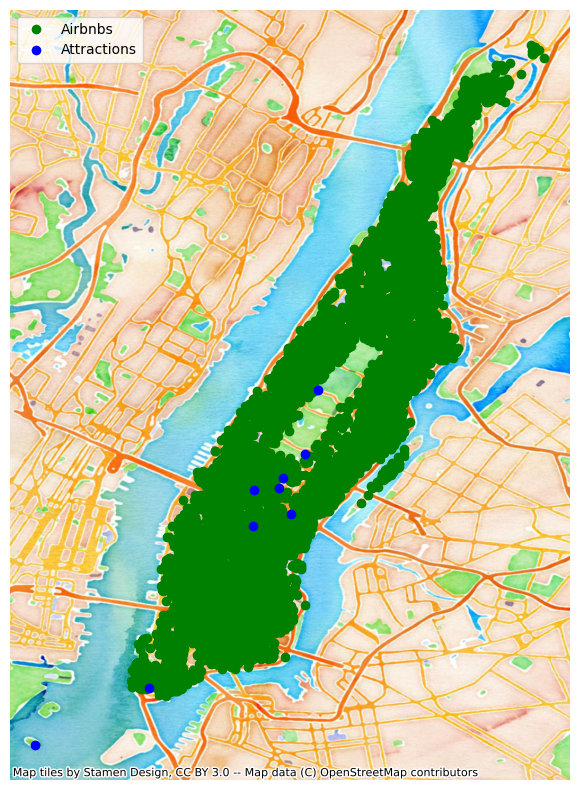

In [155]:
from matplotlib.lines import Line2D

# Bringing it together

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot all airbnb locations in green
listings_manhattan.plot(ax=ax, color="g")

# Plot all attractions in blue
nyc_attr_gpdf.plot(ax=ax, color="b")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=nyc_attr_gpdf.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)

# Remove axes
ax.set_axis_off()

# Manually creating a legend to orient audience
green_circle = Line2D([0], [0], marker='o', color='w', label='Airbnbs',
                        markerfacecolor='g', markersize=8)
blue_circle = Line2D([0], [0], marker='o', color='w', label='Attractions',
                        markerfacecolor='b', markersize=8)
plt.legend(handles=[green_circle, blue_circle])


# Display
plt.show()

In [97]:
# Calculate the distance to each attraction per airbnb
attractions = nyc_attr_gpdf.Attraction.unique()

# Converting to a projected coordinate system
nyc_attr_gpdf_p = nyc_attr_gpdf.to_crs('EPSG:2263')
listings_manhattan_p = listings_manhattan.to_crs('EPSG:2263')

# Applying a lambda function that calls geopandas distance function to calcuate the distance between each airbnb and each attraction
distances = listings_manhattan_p.geometry.apply(lambda g: nyc_attr_gpdf_p.distance(g)).head()

# Renaming the columns based on the attraction for which the distance is calculated
distances.columns = attractions
distances.head()

Central Park  Central Park Zoo  Empire State Building  Statue of Liberty  \
0  12449.130062       6442.862187            1880.199860       28574.036112   
3   8538.688680       3362.228580            5932.798876       32295.400375   
4   6816.554618      13169.697177           20803.298480       46886.737387   
5   6693.228881      13068.659750           20846.911385       47148.746689   
8   9202.788412      14578.795940           22606.795834       49590.794162   

   Rockeffeller Center  Chrysler Building  Times Square          MoMa  \
0          2674.066939        2885.323549   1617.825078   3613.682993   
3          2471.258560        5181.159022   2479.163838   1927.357948   
4         16721.114119       19146.493310  17414.384906  15698.425821   
5         16710.826727       19059.163990  17509.856678  15682.502983   
8         18399.168241       20202.275236  19690.749451  17410.219618   

   Charging Bull  
0   19487.155574  
3   23450.112153  
4   38359.075319  
5   38491.046003  
8   40325.055534

In [102]:
# To understand what the distance unit is, we run the following function
listings_manhattan_p.crs.axis_info[0].unit_name

'US survey foot'

In [103]:
# Convert from 'US survey foot' to miles
distances = distances.apply(lambda x: x/5280, axis=1)
distances.head()

Central Park  Central Park Zoo  Empire State Building  Statue of Liberty  \
0      2.357790          1.220239               0.356098           5.411749   
3      1.617176          0.636786               1.123636           6.116553   
4      1.291014          2.494261               3.940019           8.880064   
5      1.267657          2.475125               3.948279           8.929687   
8      1.742952          2.761136               4.281590           9.392196   

   Rockeffeller Center  Chrysler Building  Times Square      MoMa  \
0             0.506452           0.546463      0.306406  0.684410   
3             0.468041           0.981280      0.469539  0.365030   
4             3.166878           3.626230      3.298179  2.973187   
5             3.164929           3.609690      3.316261  2.970171   
8             3.484691           3.826188      3.729309  3.297390   

   Charging Bull  
0       3.690749  
3       4.441309  
4       7.264976  
5       7.289971  
8       7.637321

In [119]:
# Check to see which locations are less than 2 miles

distances_1mi = distances.apply(lambda x: x <=1, axis=1).sum(axis=1)
distances_2mi = distances.apply(lambda x: x <=2, axis=1).sum(axis=1)
distances_3mi = distances.apply(lambda x: x <=3, axis=1).sum(axis=1)
distances_4mi = distances.apply(lambda x: x <=4, axis=1).sum(axis=1)
distances_5mi = distances.apply(lambda x: x <=5, axis=1).sum(axis=1)
distances_6mi = distances.apply(lambda x: x <=6, axis=1).sum(axis=1)

# Creating a dataframe combining all the distance bands
distance_df = pd.concat([distances_1mi,distances_2mi,distances_3mi,distances_4mi,distances_5mi,distances_6mi], axis=1)
distance_df.columns = ['Attr_1mi','Attr_2mi','Attr_3mi','Attr_4mi','Attr_5mi','Attr_6mi']
distance_df.head()

Attr_1mi  Attr_2mi  Attr_3mi  Attr_4mi  Attr_5mi  Attr_6mi
0         5         6         7         8         8         9
3         5         7         7         7         8         8
4         0         1         3         7         7         7
5         0         1         3         7         7         7
8         0         1         2         6         7         7

In [122]:
# Joining back to the listings geopandas df
listings_manhattan = listings_manhattan.merge(distances, left_index=True, right_index=True)
listings_manhattan = listings_manhattan.merge(distance_df, left_index=True, right_index=True)

#listings_manhattan.head()

id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20220603182654   2022-06-04   
3  5178  https://www.airbnb.com/rooms/5178  20220603182654   2022-06-04   
4  5203  https://www.airbnb.com/rooms/5203  20220603182654   2022-06-03   
5  5295  https://www.airbnb.com/rooms/5295  20220603182654   2022-06-03   
8  6872  https://www.airbnb.com/rooms/6872  20220603182654   2022-06-04   

                                                name  \
0                              Skylit Midtown Castle   
3                   Large Furnished Room Near B'way　   
4                 Cozy Clean Guest Room - Family Apt   
5                   Beautiful 1br on Upper West Side   
8  Uptown Sanctuary w/ Private Bath (Month to Month)   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
3  Please don’t expect the luxury here just a bas...   
4  Our best guests are seeking a safe, clean, spa...   
5  <b>The space</b><br />Beautiful 1br on the Upp...   
8  A charming month-to-month home away from home ...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
3    Theater district, many restaurants around here.   
4  Our neighborhood is full of restaurants and ca...   
5                                                NaN   
8  This sweet Harlem sanctuary is a 10-20 minute ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
3  https://a0.muscache.com/pictures/12065/f070997...     8967   
4  https://a0.muscache.com/pictures/103776/b37157...     7490   
5  https://a0.muscache.com/pictures/17395/dfed075...     7702   
8  https://a0.muscache.com/pictures/miso/Hosting-...    16104   

                                  host_url  ... Chrysler Building  \
0   https://www.airbnb.com/users/show/2845  ...          0.546463   
3   https://www.airbnb.com/users/show/8967  ...          0.981280   
4   https://www.airbnb.com/users/show/7490  ...          3.626230   
5   https://www.airbnb.com/users/show/7702  ...          3.609690   
8  https://www.airbnb.com/users/show/16104  ...          3.826188   

  Times Square      MoMa Charging Bull Attr_1mi Attr_2mi Attr_3mi Attr_4mi  \
0     0.306406  0.684410      3.690749        5        6        7        8   
3     0.469539  0.365030      4.441309        5        7        7        7   
4     3.298179  2.973187      7.264976        0        1        3        7   
5     3.316261  2.970171      7.289971        0        1        3        7   
8     3.729309  3.297390      7.637321        0        1        2        6   

  Attr_5mi Attr_6mi  
0        8        9  
3        8        8  
4        7        7  
5        7        7  
8        7        7  

[5 rows x 90 columns]